In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount ('/content/drive')

datasheet = '/content/drive/My Drive/Datasheet/dataset_sdn.csv'
df = pd.read_csv(datasheet)

Mounted at /content/drive


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104345 entries, 0 to 104344
Data columns (total 23 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   dt           104345 non-null  int64  
 1   switch       104345 non-null  int64  
 2   src          104345 non-null  object 
 3   dst          104345 non-null  object 
 4   pktcount     104345 non-null  int64  
 5   bytecount    104345 non-null  int64  
 6   dur          104345 non-null  int64  
 7   dur_nsec     104345 non-null  int64  
 8   tot_dur      104345 non-null  float64
 9   flows        104345 non-null  int64  
 10  packetins    104345 non-null  int64  
 11  pktperflow   104345 non-null  int64  
 12  byteperflow  104345 non-null  int64  
 13  pktrate      104345 non-null  int64  
 14  Pairflow     104345 non-null  int64  
 15  Protocol     104345 non-null  object 
 16  port_no      104345 non-null  int64  
 17  tx_bytes     104345 non-null  int64  
 18  rx_bytes     104345 non-

In [3]:
from sklearn.preprocessing import OneHotEncoder

df['Protocol'] = df ['Protocol'].astype(str)
encoder = OneHotEncoder(sparse_output=False)
encoded_clean = encoder.fit_transform(df[['Protocol']]).astype(str)
encoded_clean = pd.DataFrame(
    encoded_clean,
    columns= encoder.get_feature_names_out(['Protocol']),
    index = df.index
)
df = pd.concat([df.drop(columns=['Protocol']), encoded_clean], axis = 1)

In [4]:
df.columns

Index(['dt', 'switch', 'src', 'dst', 'pktcount', 'bytecount', 'dur',
       'dur_nsec', 'tot_dur', 'flows', 'packetins', 'pktperflow',
       'byteperflow', 'pktrate', 'Pairflow', 'port_no', 'tx_bytes', 'rx_bytes',
       'tx_kbps', 'rx_kbps', 'tot_kbps', 'label', 'Protocol_ICMP',
       'Protocol_TCP', 'Protocol_UDP'],
      dtype='object')

In [5]:
Features = [
    'dt','dur','dur_nsec','tot_dur','pktrate','Protocol_ICMP','Protocol_TCP','Protocol_UDP',
    'port_no','tx_kbps','rx_kbps','tot_kbps'
]
df_clean = df[Features]

In [21]:
from sklearn.model_selection import train_test_split

X = df_clean.astype('float32')
y = df['label']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state=42, stratify =y
)

In [23]:
df['label'].value_counts()

,count
label,
0,63561
1,40784


In [24]:
# Membuat model XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=500,
    learning_rate = 0.1,
    max_depth = 6,
    subsample = 0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train.value_counts()[0]/ y_train.value_counts()[1]),
    eval_metrics='logloss',
    use_label_encoder=False
)

In [25]:
#Training Model
model.fit(
    X_train, y_train,
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:40:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              eval_metrics='logloss', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, ...)

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Prediksi di training set untuk mengetahui overfit sebuah model
y_train_pred = model.predict(X_train)

# Hitung akurasi
train_acc = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_acc)

Training Accuracy: 0.9997604101777756


In [34]:
# Evaluate model menggunakan datasheet test
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12712
           1       1.00      1.00      1.00      8157

    accuracy                           1.00     20869
   macro avg       1.00      1.00      1.00     20869
weighted avg       1.00      1.00      1.00     20869



In [35]:
print('Akurasi :', acc)

Akurasi : 0.9987541329244334


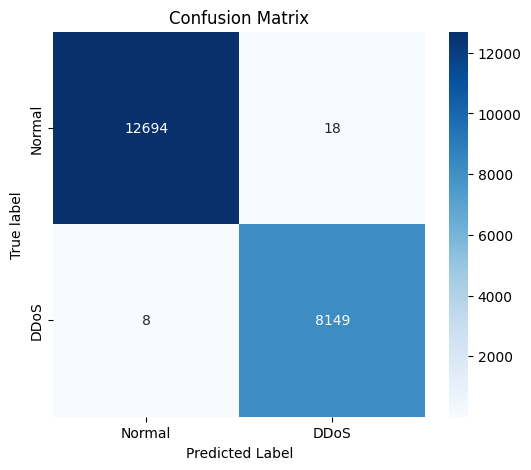

In [36]:
# Grafik evaluasi confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

label = ['Normal','DDoS']
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = label,
            yticklabels = label)
plt.xlabel('Predicted Label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

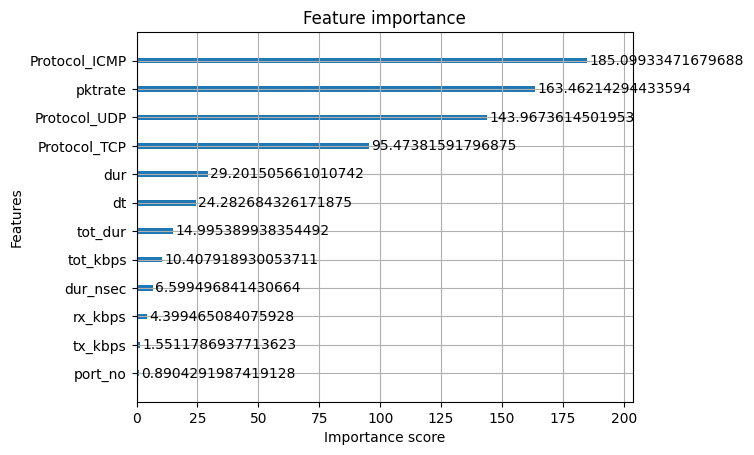

In [37]:
# Top Fitur XGBoost
from xgboost import plot_importance
plot_importance(model, importance_type='gain')
plt.show()

In [38]:
import joblib
from google.colab import files

joblib.dump(model, 'XGBoost_DetectionDDoS.pkl')
files.download('XGBoost_DetectionDDoS.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>